In [220]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from networkx.algorithms import community as cm

### Introdução 

Uma das tarefas que é comum em análise de redes complexas é agrupar os vértices da rede em subconjuntos, chamados de comunidades, de modo que os vértices mais similares fiquem juntos em uma comunidade. 

A ideia central é entender um pouco sobre como os nós tendem a se organizar dentro da rede através da observação dos padrões de ligação que os mesmos possuem.

Problemas de detecção de comunidades são similares a problemas de partição em grafos, mas em geral nestes últimos já há uma quantidade pré-determinada de grupos e dos tamanhos dos mesmos no qual o grafo deve ser particionado, o que não ocorre em geral com os problemas de detecção de comunidades nos quais o tamanho e a quantidade de comunidades a serem detectadas não são previamente conhecidos

### Modularidade

Modularidade equivale ao coeficiente de assortatividade não normalizado para atributos categóricos, sendo que aqui os atributos categóricos identificam as comunidades
aos quais os nós pertencem.

- **nx.karate_club_graph()** 

Returns Zachary's Karate Club graph.

Each node in the returned graph has a node attribute 'club' that indicates the name of the club to which the member represented by that node belongs, either 'Mr. Hi' or 'Officer'. 

Each edge has a weight based on the number of contexts in which that edge's incident node members interacted.

- **louvain_communities()**: 

Find the best partition of a graph using the Louvain Community Detection Algorithm.

Louvain Community Detection Algorithm is a simple method to extract the community structure of a network. 
This is a heuristic method based on modularity optimization.

The algorithm works in 2 steps. 
On the first step it assigns every node to be in its own community and then for each node it tries to find the maximum positive modularity gain by moving each node to all of its neighbor communities. 
If no positive gain is achieved the node remains in its original community.

- **nx.community.greedy_modularity_communities(G)** 

Find communities in G using greedy modularity maximization.

This function uses Clauset-Newman-Moore greedy modularity maximization to find the community partition with the largest modularity.

Greedy modularity maximization begins with each node in its own community and repeatedly joins the pair of communities that lead to the largest modularity until no further increase in modularity is possible (a maximum). 

- **nx.modularity()**

Returns the modularity of the given partition of the graph.

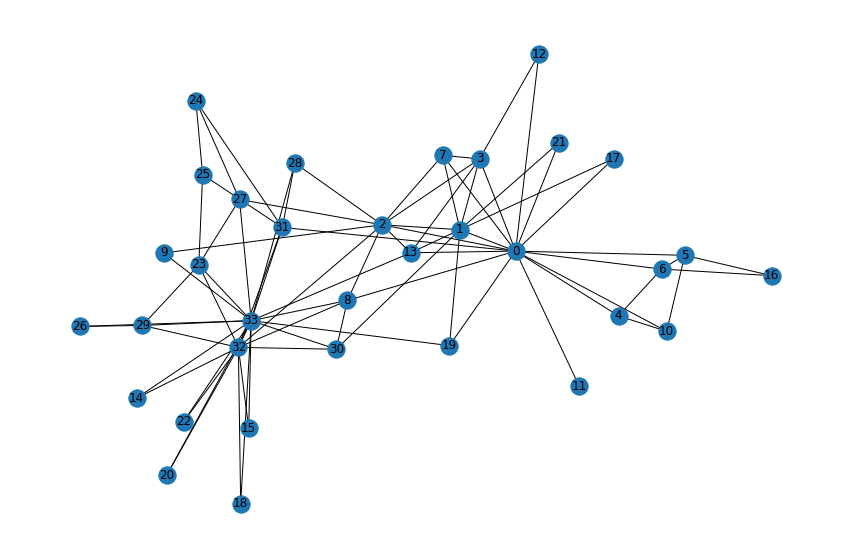

In [221]:
# Exemplo

G = nx.karate_club_graph()

fig, ax = plt.subplots(1,1,figsize=(15,10))

nx.draw(G,with_labels=True)

In [222]:
# Exemplo

comm = nx.community.louvain_communities(G, seed=123)
for it in comm:
    print(sorted(it))

[1, 2, 3, 7, 12, 13]
[0, 4, 5, 6, 10, 11, 16, 17, 19, 21]
[23, 24, 25, 27, 28, 31]
[8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]


In [223]:
# Exemplo

c = nx.community.greedy_modularity_communities(G)
for it in c:
    print(sorted(it))

[8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[1, 2, 3, 7, 9, 12, 13, 17, 21]
[0, 4, 5, 6, 10, 11, 16, 19]


**Exemplo**

Utilize os algoritmos no exemplo dos personagens do segundo livro da saga de Harry Potter.

In [224]:
atri = pd.read_csv('../data/harrypotter/hpattributes.txt', sep='\t')
ares = pd.read_csv('../data/harrypotter/hpbook2.txt', sep=' ', header=None)
nome = pd.read_csv('../data/harrypotter/hpnames.txt', sep='\t')

In [225]:
# criando a rede

gpotter = nx.DiGraph()

n = atri.shape[0]

for k in range(n):
    gpotter.add_node(k,
                     nome = nome['name'][k],
                     ano = atri['schoolyear'][k],
                     gen = atri['gender'][k],
                     casa = atri['house'][k])

for k in range(n):
    for m in range(n):
        if ares.values[k][m] == 1:
            gpotter.add_edge(k,m)

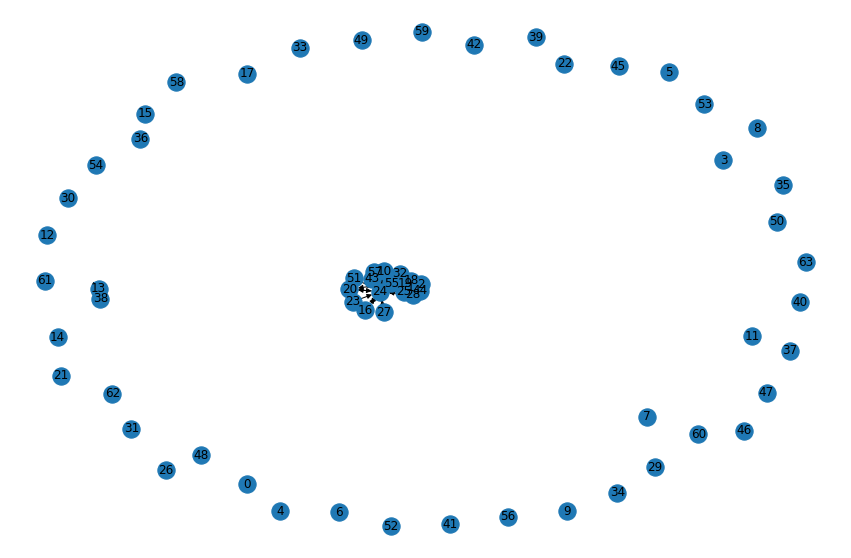

In [226]:
fig, ax = plt.subplots(1,1,figsize=(15,10))

nx.draw(gpotter,with_labels=True)

In [227]:
# matriz de adjacencia esparsa
A = nx.adjacency_matrix(gpotter)

# apagando os nos isolados
isolados = []
for k in range(n):
    if np.sum(A[[k],:]) == 0:
        isolados.append(k)
        gpotter.remove_node(k)

print(len(isolados), 'nos isolados.')

44 nos isolados.


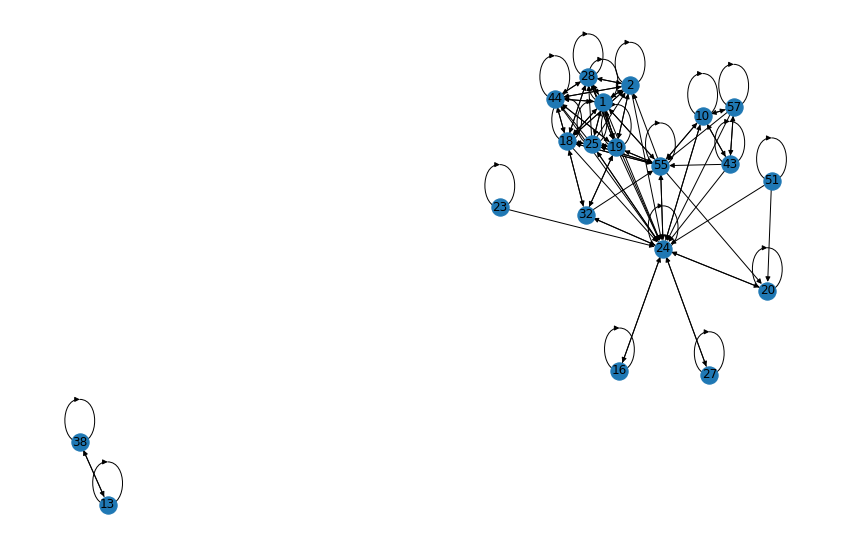

In [228]:
fig, ax = plt.subplots(1,1,figsize=(15,10))

nx.draw(gpotter,with_labels=True)

Para comparar os resultados, no algoritmo de **Clauset-Newman-Moore** só salvamos o mesmo número de comunidades que as devolvidas pelo algoritmo de **Louvain**. 

In [229]:
comsl = cm.louvain_communities(gpotter)
comsc = cm.greedy_modularity_communities(gpotter,cutoff=len(comsl))

print('Modularidade - Louvain: {:.3f}'.format(cm.modularity(gpotter,comsl)))
print('Modularidade - CNM    : {:.3f}'.format(cm.modularity(gpotter,comsc)))

Modularidade - Louvain: 0.371
Modularidade - CNM    : 0.371


In [230]:
plt.close('all')

pos = nx.circular_layout(gpotter)

coresp = {0:'lightskyblue',
          1:'steelblue',
          2:'gray',
          3:'pink',
          4:'magenta',
          5:'violet',
          6: 'mediumorchid'}

coresl = []
for no in gpotter.nodes():
    for k in range(len(comsl)):
        if no in comsl[k]:
            coresl.append(coresp[k])
            break

coresc = []
for no in gpotter.nodes():
    for k in range(len(comsc)):
        if no in comsc[k]:
            coresc.append(coresp[k])
            break
    
etiquetas = nx.get_node_attributes(gpotter, 'nome')

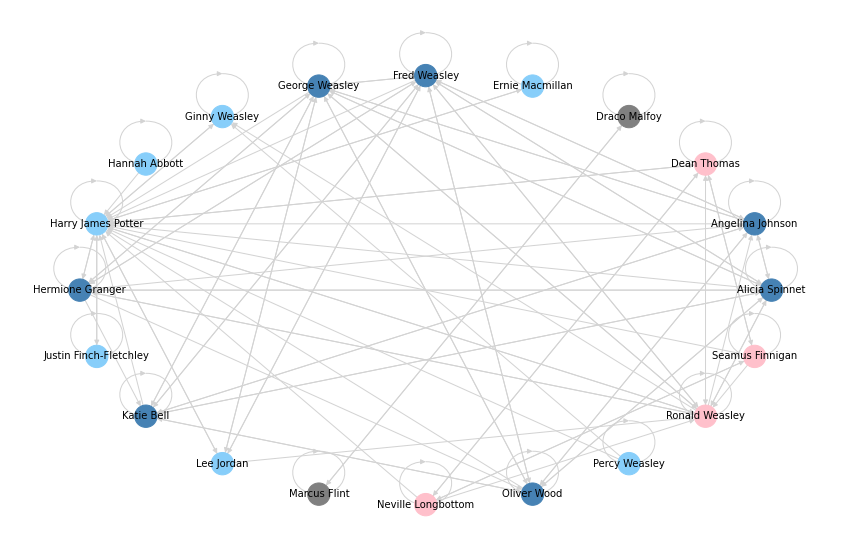

In [231]:
fig, ax = plt.subplots(1,1,figsize=(15,10))

nx.draw_networkx(gpotter,
                 pos=pos,
                 edge_color='lightgray',
                 node_size = 500,
                 labels=etiquetas,
                 font_size=10, 
                 node_color=coresl)

plt.box(False)
plt.show()

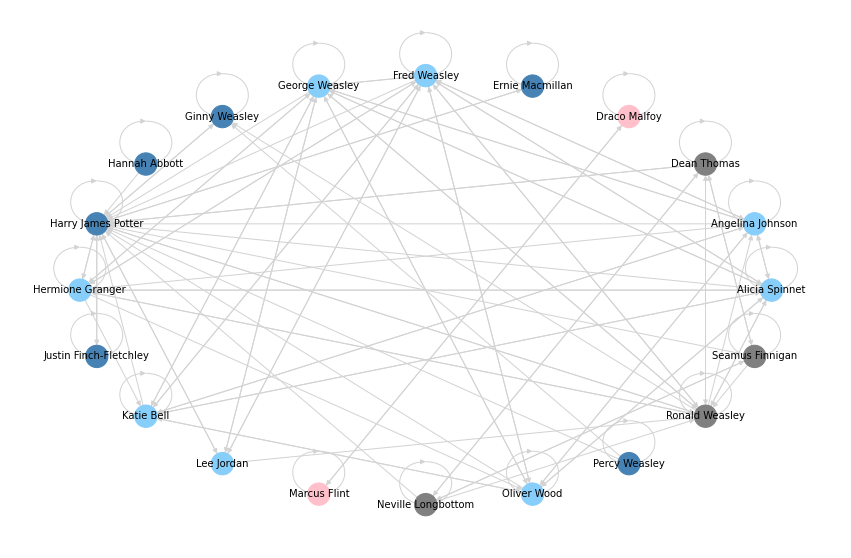

In [232]:
#plt.figure()

fig, ax = plt.subplots(1,1,figsize=(15,10))

nx.draw_networkx(gpotter,
                 pos=pos,
                 edge_color='lightgray',
                 node_size = 500,
                 labels=etiquetas,
                 font_size=10, 
                 node_color=coresc)

plt.box(False)
plt.show()

### CONCOR

É um dos primeiros e mais usados métodos para detectar comunidades. 

Ele é baseado na convergência de correlações iteradas.

O método CONCOR aplicado uma única vez, divide o conjunto de nós em no máximo duas comunidades. 
Se mais comunidades forem necessárias, pode-se aplicar novamente o método CONCOR em uma comunidade encontrada anteriormente, dividindo-a em duas.

**Exemplo**

Considerar novamente o exemplo do livro 2 da saga Harry Potter. 

Recorde que as ligações na rede representam suporte emocional e, portanto, trata-se de uma rede direcionada com matriz de adjacência não simétrica.

Usamos o algoritmo **CONCOR** para achar uma divisão em duas comunidades. 

Excluímos os nós isolados. 
Estes vértices podem ser considerados uma comunidade separada, mas alguns deles correspondem a personagens que não fazem parte do livro. 

A convergência do algoritmo é detectada usando a função **all_close** de Numpy porque, trabalhando com aritmética de ponto flutante, existe a possibilidade de que os elementos da matriz $C_k$ não fiquem exatamente iguais a $+-1$. 

As correlações são feitas usando a função **corr_coef** de Numpy. 

A função **adjacency_matrix** devolve a matriz em um formato especial para matrizes esparsas. 

Antes de começar o algoritmo CONCOR, primeiro convertemos a matriz a um formato denso com **todense**.

In [233]:
gpotter = nx.DiGraph()

n = atri.shape [0]

# Primeiro agregamos os nós
for k in range(n):
    gpotter.add_node(k,
                     nome = nome['name'][k],
                     ano = atri['schoolyear'][k],
                     gen = atri['gender'][k],
                     casa = atri['house'][k])
    
# Construímos a rede
for k in range(n):
    for m in range(n):
        if ares.values[k][m] == 1:
            gpotter.add_edge(k,m)            

In [234]:
# Matriz de adjacência esparsa
A = nx . adjacency_matrix ( gpotter )

# Apagamos os nós isolados :
isolados = []
for k in range(n):
    if np.sum(A[[k],:]) == 0:
        isolados.append(k)
        gpotter.remove_node(k)

print(len(isolados), 'nos isolados')

44 nos isolados


In [235]:
# matriz de adjacencia esparsa
A = nx.adjacency_matrix(gpotter)

# matriz de adjacencia densa
A = np.array(A.todense(),dtype=float)

In [236]:
# algoritmo CONCOR
C = A.copy()

while not np.allclose(np.abs(C), np.ones_like(C), atol=1e-10):
    C = np.corrcoef(C)

C = np.round(C)

**allclose()**

Returns True if two arrays are element-wise equal within a tolerance.

**ones_like()**

Return an array of ones with the same shape and type as a given array.

 **corrcoef()**

Return Pearson product-moment correlation coefficients.

In [237]:
# algoritmo CONCOR

com1 = []
com2 = []

nos  = list(gpotter.nodes)

com1.append(nos[0])

for k in range(1,len(nos)):
    if C[0,k] > 0:
        com1.append(nos[k])
    else:
        com2.append(nos[k])

In [238]:
print('Comunidade 1:')
for k in range(len(com1)):
    print(gpotter.nodes[com1[k]]['nome'])

Comunidade 1:
Alicia Spinnet
Angelina Johnson
Fred Weasley
George Weasley
Hermione Granger
Katie Bell
Lee Jordan
Oliver Wood
Ronald Weasley


In [239]:
print('Comunidade 2:')
for k in range(len(com2)):
    print(gpotter.nodes[com2[k]]['nome'])

Comunidade 2:
Dean Thomas
Draco Malfoy
Ernie Macmillan
Ginny Weasley
Hannah Abbott
Harry James Potter
Justin Finch-Fletchley
Marcus Flint
Neville Longbottom
Percy Weasley
Seamus Finnigan


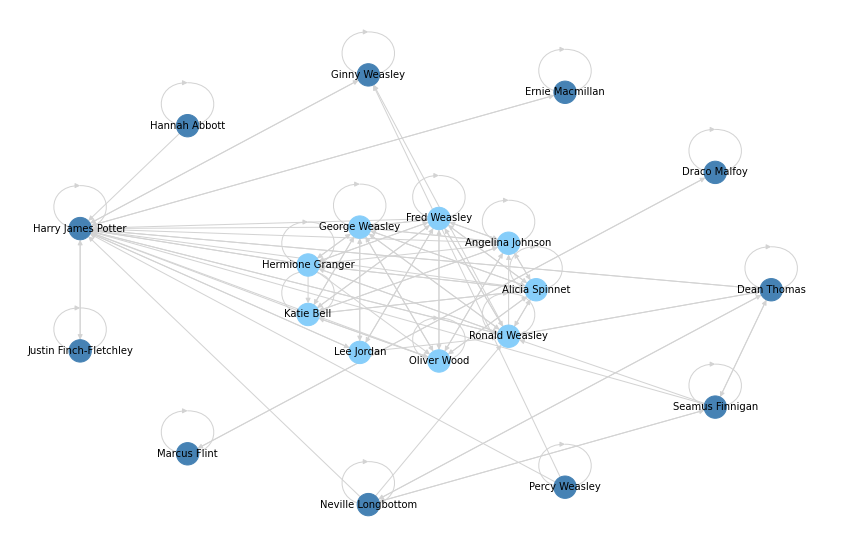

In [240]:
plt.close('all')

fig, ax = plt.subplots(1,1,figsize=(15,10))

pos = nx.circular_layout(gpotter)

for k in range(len(com1)):
    pos[com1[k]][0] = 100*np.cos(2*np.pi*k/len(com1))
    pos[com1[k]][1] = 100*np.sin(2*np.pi*k/len(com1))

for k in range(len(com2)):
    pos[com2[k]][0] = 300*np.cos(2*np.pi*k/len(com2))
    pos[com2[k]][1] = 300*np.sin(2*np.pi*k/len(com2))    

cores = []
for no in gpotter.nodes():
    if no in com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')
    
etiquetas = nx.get_node_attributes(gpotter, 'nome')

nx.draw_networkx(gpotter,pos=pos,edge_color='lightgray',
                 node_size = 500, labels=etiquetas,
                 font_size=10, node_color=cores)

plt.box(False)
plt.show()

Os problemas de divisão de um grafo em comunidades são, comumente, muito complexos. 

Daí que existam algoritmos heurísticos ou baseados em optimizações locais progressivas(métodos greedy). 

Os scripts python a seguir minimiza a razão entre o número de arestas que ligam dois grupos e o produto dos tamanhos dos dois grupos, 
aplicado a uma rede de personagens do livro 2 da saga Harry Potter.

O sub-pacote **algorithms.community** do Networkx contém várias funções relacionadas a busca de comunidades em redes.

O primeiro número que devolve a função **partition_quality** é a razão entre o número de arestas internas aos grupos e o número total de arestas. 

In [244]:
mper = +np.inf
for ini in gpotter.nodes:
    com1 = set([ini])
    com2 = set(nos) - com1
    
    mgan = -1
    while mgan < 0:
        cv, pe = cm.partition_quality(gpotter,[com1,com2])
        ra = (1-cv)/(len(com1)*len(com2)) 
        mgan = +np.inf
        mno  = -1
        for no in com2:
            ncom1 = com1.union(set([no]))
            ncom2 = com2 - set([no])
            cv,pe = cm.partition_quality(gpotter,[ncom1,ncom2])
            nra   = (1-cv)/(len(ncom1)*len(ncom2))
            ng    = nra-ra
            if ng < mgan:
                mgan = ng
                mno  = no
        if mgan < 0:
            com1.add(mno)
            com2.remove(mno)
    
    cv,pe = cm.partition_quality(gpotter,[com1,com2])            
    ra = (1-cv)/(len(com1)*len(com2)) 

    if ra < mper:
        mper = ra
        mcom1 = com1.copy()
        mcom2 = com2.copy()

In [245]:
com1 = list(mcom1)
com2 = list(mcom2)

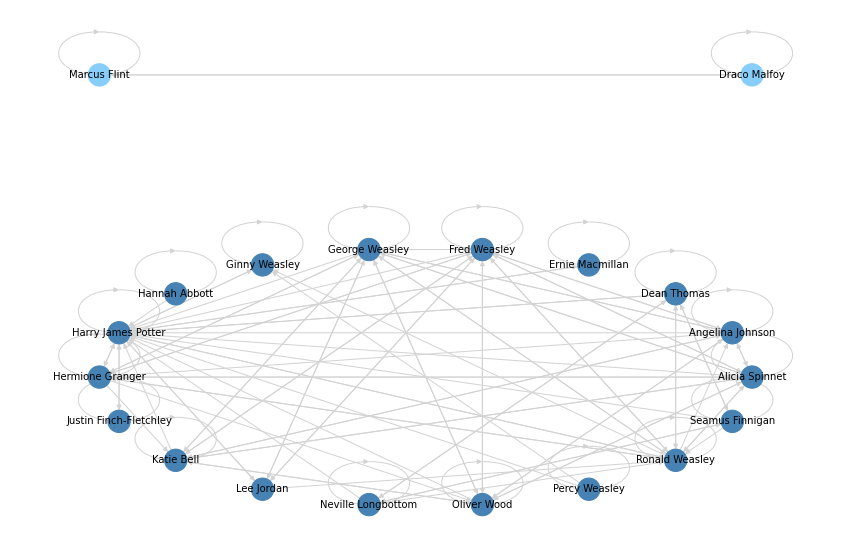

In [248]:
plt.close('all')

fig, ax = plt.subplots(1,1,figsize=(15,10))

pos = nx.circular_layout(gpotter)

for k in range(len(com1)):
    pos[com1[k]][0] = 300*np.cos(2*np.pi*k/len(com1))
    pos[com1[k]][1] = 300*np.sin(2*np.pi*k/len(com1))+700

for k in range(len(com2)):
    pos[com2[k]][0] = 300*np.cos(2*np.pi*k/len(com2))
    pos[com2[k]][1] = 300*np.sin(2*np.pi*k/len(com2))    

cores = []
for no in gpotter.nodes():
    if no in com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')

etiquetas = nx.get_node_attributes(gpotter, 'nome')

nx.draw_networkx(gpotter,
                 pos=pos,
                 edge_color='lightgray',
                 node_size = 500, 
                 labels=etiquetas,
                 font_size=10, 
                 node_color=cores)

plt.box(False)
plt.show()

Um algoritmo de bisseção muito conhecido é o algoritmo de **Kernighan e Lin**. 

Este algoritmo **greedy** começa com uma partição do grafo (dada ou ao acaso) e prossegue trocando dois nós, um de cada grupo, de maneira de aprimorar a partição.

A seguir aplicamos o algoritmo **Kernighan e Lin** a uma rede de personagens do segundo livro da saga Harry Potter.

**cm.kernighan_lin_bisection()**

Partition a graph into two blocks using the **Kernighan–Lin** algorithm.

This algorithm partitions a network into two sets by iteratively swapping pairs of nodes to reduce the edge cut between the two sets. 

The pairs are chosen according to a modified form of **Kernighan-Lin**, which moves node individually, alternating between sides to keep the bisection balanced.

In [249]:
# Algoritmo Kernighan e Lin aplicado a uma rede de personagens do segundo livro da saga Harry Potter.
com1, com2 = cm.kernighan_lin_bisection(gpotter.to_undirected(), max_iter =100)

In [250]:
com1 = list(com1)
com2 = list(com2)

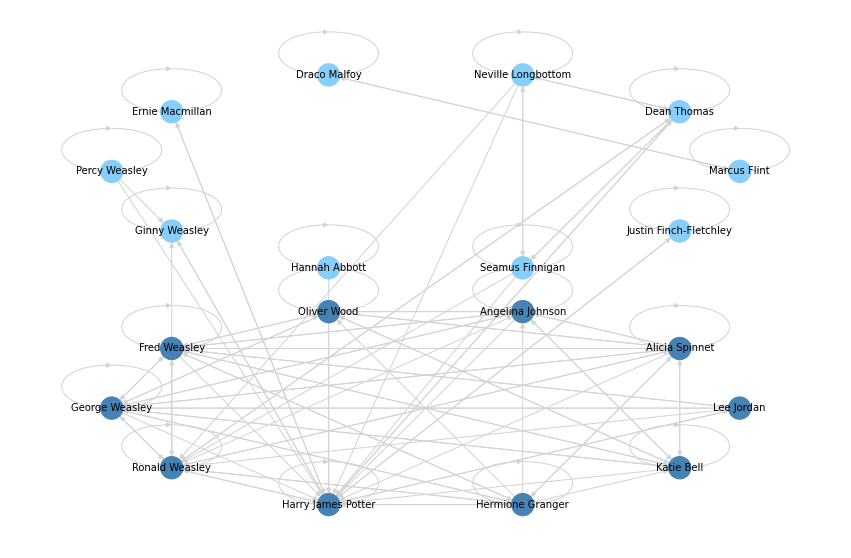

In [251]:
plt.close('all')

fig, ax = plt.subplots(1,1,figsize=(15,10))

pos = nx.circular_layout(gpotter)

for k in range(len(com1)):
    pos[com1[k]][0] = 300*np.cos(2*np.pi*k/len(com1))
    pos[com1[k]][1] = 300*np.sin(2*np.pi*k/len(com1))+700

for k in range(len(com2)):
    pos[com2[k]][0] = 300*np.cos(2*np.pi*k/len(com2))
    pos[com2[k]][1] = 300*np.sin(2*np.pi*k/len(com2))    

cores = []
for no in gpotter.nodes():
    if no in com1:
        cores.append('lightskyblue')
    else:
        cores.append('steelblue')

etiquetas = nx.get_node_attributes(gpotter, 'nome')

#plt.figure()
nx.draw_networkx(gpotter,pos=pos,edge_color='lightgray',
                 node_size = 500, labels=etiquetas,
                 font_size=10, node_color=cores)
plt.box(False)
plt.show()

### Remoção de arestas

O método da remoção de arestas consiste em ir removendo arestas da rede, de forma que as componentes resultantes formem as comunidades. 

O algoritmo mais utilizado é o de **Girvan-Newman** que remove as arestas que possuam maior intermediação. 

A intermediação de uma aresta consiste do número de caminhos geodésicos da rede que passam por esta aresta. 

Um critério de parada para o algoritmo pode ser fixar um valor máximo para a intermediação de uma aresta na rede resultante após cada passo.

O algoritmo continua o processo até que todos os nós fiquem isolados. 
Graficamente, isto pode ser apresentado com um dendrograma.

A função **girvan_newman** do pacote Networkx implementa o algoritmo de **Girvan-Newman**. 

Por padrão, a **girvan_newman** usa intermediação como métrica. 

No entanto, ela pode usar qualquer métrica que seja definida pelo usuário. 

**nx.community()**

Functions for computing and measuring community structure.

The community subpackage can be accessed by using **nx.community**, then accessing the functions as attributes of community. 


**nx.community.girvan_newman()**

Finds communities in a graph using the Girvan–Newman method.

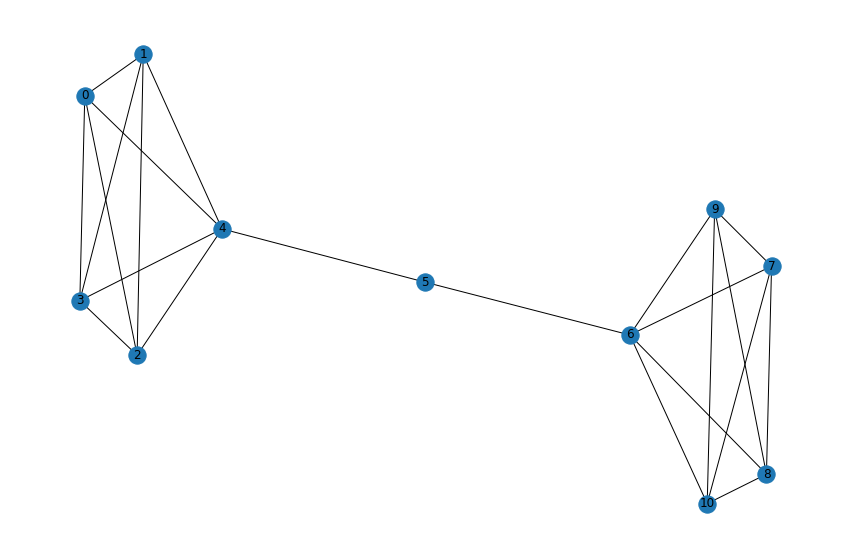

In [260]:
# example 

G = nx.barbell_graph(5,1)

fig, ax = plt.subplots(1,1,figsize=(15,10))

nx.draw(G,with_labels=True)

In [268]:
# Exemplo

comm = nx.community.girvan_newman(G)

top_level_comm = next(comm)

next_level_comm = next(comm)

print(sorted(map(sorted, top_level_comm)))
print(sorted(map(sorted, next_level_comm)))

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]]
[[0, 1], [2, 3, 4], [5, 6, 7, 8, 9]]


In [269]:
comm1 = nx.community.girvan_newman(G)

for it in comm1:
    print(it)

({0, 1, 2, 3, 4}, {5, 6, 7, 8, 9})
({0, 1}, {2, 3, 4}, {5, 6, 7, 8, 9})
({0, 1}, {2, 3, 4}, {5, 6}, {8, 9, 7})
({0, 1}, {2}, {3, 4}, {5, 6}, {8, 9, 7})
({0, 1}, {2}, {3, 4}, {5, 6}, {7}, {8, 9})
({0}, {1}, {2}, {3, 4}, {5, 6}, {7}, {8, 9})
({0}, {1}, {2}, {3}, {4}, {5, 6}, {7}, {8, 9})
({0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8, 9})
({0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9})


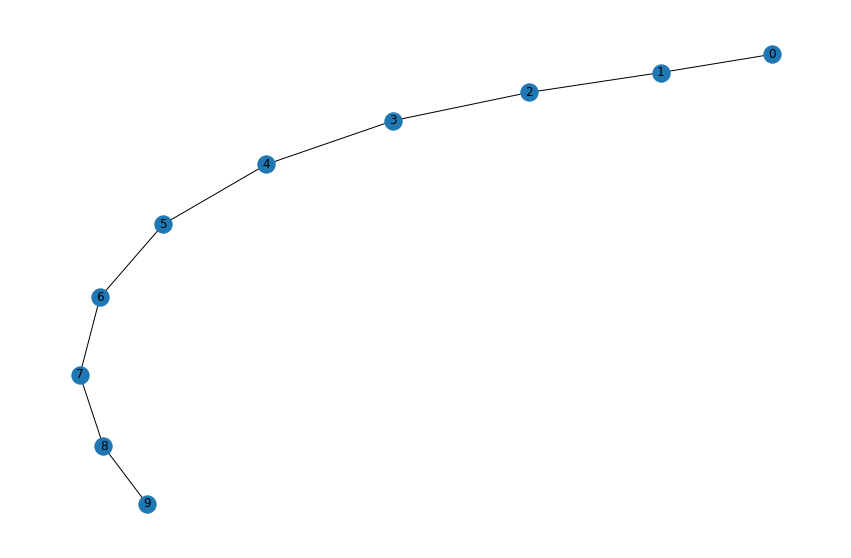

In [270]:
# Exemplo

G = nx.path_graph(10)
#G = nx.path_graph(8)

fig, ax = plt.subplots(1,1,figsize=(15,10))

nx.draw(G,with_labels=True)

In [271]:
comp = nx.community.girvan_newman(G)

#tuple(sorted(c) for c in next(comp))

tuple(sorted(c) for c in comp)

([{0, 1, 2, 3, 4}, {5, 6, 7, 8, 9}],
 [{0, 1}, {2, 3, 4}, {5, 6, 7, 8, 9}],
 [{0, 1}, {2, 3, 4}, {5, 6}, {7, 8, 9}],
 [{0, 1}, {2}, {3, 4}, {5, 6}, {7, 8, 9}],
 [{0, 1}, {2}, {3, 4}, {5, 6}, {7}, {8, 9}],
 [{0}, {1}, {2}, {3, 4}, {5, 6}, {7}, {8, 9}],
 [{0}, {1}, {2}, {3}, {4}, {5, 6}, {7}, {8, 9}],
 [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8, 9}],
 [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}])

In [265]:
# To just choose an edge to remove based on the weight:

from operator import itemgetter

edges = G.edges()
nx.set_edge_attributes(G, {(u, v): v for u, v in edges}, "weight")

def heaviest(G):
    u, v, w = max(G.edges(data="weight"), key=itemgetter(2))
    return (u, v)

comp = nx.community.girvan_newman(G, most_valuable_edge=heaviest)

#tuple(sorted(c) for c in next(comp))

tuple(sorted(c) for c in comp)

([{0, 1, 2, 3, 4, 5, 6, 7, 8}, {9}],
 [{0, 1, 2, 3, 4, 5, 6, 7}, {8}, {9}],
 [{0, 1, 2, 3, 4, 5, 6}, {7}, {8}, {9}],
 [{0, 1, 2, 3, 4, 5}, {6}, {7}, {8}, {9}],
 [{0, 1, 2, 3, 4}, {5}, {6}, {7}, {8}, {9}],
 [{0, 1, 2, 3}, {4}, {5}, {6}, {7}, {8}, {9}],
 [{0, 1, 2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}],
 [{0, 1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}],
 [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}])

In [266]:
# To utilize edge weights when choosing an edge with, for example, the highest betweenness centrality:

from networkx import edge_betweenness_centrality as betweenness

def most_central_edge(G):
    centrality = betweenness(G, weight="weight")
    return max(centrality, key=centrality.get)

comp = nx.community.girvan_newman(G, most_valuable_edge=most_central_edge)

#tuple(sorted(c) for c in next(comp))

tuple(sorted(c) for c in comp)

([{0, 1, 2, 3, 4}, {5, 6, 7, 8, 9}],
 [{0, 1}, {2, 3, 4}, {5, 6, 7, 8, 9}],
 [{0, 1}, {2, 3, 4}, {5, 6}, {7, 8, 9}],
 [{0, 1}, {2}, {3, 4}, {5, 6}, {7, 8, 9}],
 [{0, 1}, {2}, {3, 4}, {5, 6}, {7}, {8, 9}],
 [{0}, {1}, {2}, {3, 4}, {5, 6}, {7}, {8, 9}],
 [{0}, {1}, {2}, {3}, {4}, {5, 6}, {7}, {8, 9}],
 [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8, 9}],
 [{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}])

O scripty a seguir a função **girvan_newman** é aplicada a rede de personagens do livro 2 da saga de Harry Potter.

In [272]:
com = cm.girvan_newman(gpotter)
com = list(com)

In [273]:
for it in gpotter.nodes():
    print(it, ':', gpotter.nodes[it]['nome'])

1 : Alicia Spinnet
2 : Angelina Johnson
10 : Dean Thomas
13 : Draco Malfoy
16 : Ernie Macmillan
18 : Fred Weasley
19 : George Weasley
20 : Ginny Weasley
23 : Hannah Abbott
24 : Harry James Potter
25 : Hermione Granger
27 : Justin Finch-Fletchley
28 : Katie Bell
32 : Lee Jordan
38 : Marcus Flint
43 : Neville Longbottom
44 : Oliver Wood
51 : Percy Weasley
55 : Ronald Weasley
57 : Seamus Finnigan


In [274]:
for it in com:
    print(it)

({32, 1, 2, 10, 43, 44, 18, 19, 20, 23, 51, 55, 24, 25, 27, 28, 57}, {13, 38}, {16})
({32, 1, 2, 10, 43, 44, 18, 19, 20, 51, 55, 24, 25, 27, 28, 57}, {13, 38}, {16}, {23})
({32, 1, 2, 10, 43, 44, 18, 19, 20, 51, 55, 24, 25, 28, 57}, {13, 38}, {16}, {23}, {27})
({32, 1, 2, 10, 43, 44, 18, 19, 55, 24, 25, 28, 57}, {13, 38}, {16}, {51, 20}, {23}, {27})
({32, 1, 2, 44, 18, 19, 55, 24, 25, 28}, {57, 10, 43}, {13, 38}, {16}, {51, 20}, {23}, {27})
({1, 2, 44, 18, 19, 55, 24, 25, 28}, {57, 10, 43}, {13, 38}, {16}, {51, 20}, {23}, {27}, {32})
({1, 2, 44, 18, 19, 24, 25, 28}, {57, 10, 43}, {13, 38}, {16}, {51, 20}, {23}, {27}, {32}, {55})
({1}, {2, 44, 18, 19, 24, 25, 28}, {57, 10, 43}, {13, 38}, {16}, {51, 20}, {23}, {27}, {32}, {55})
({1}, {2}, {57, 10, 43}, {13, 38}, {16}, {44, 18, 19, 24, 25, 28}, {51, 20}, {23}, {27}, {32}, {55})
({1}, {2}, {10}, {13, 38}, {16}, {44, 18, 19, 24, 25, 28}, {51, 20}, {23}, {27}, {32}, {57, 43}, {55})
({1}, {2}, {10}, {13}, {16}, {44, 18, 19, 24, 25, 28}, {51, 

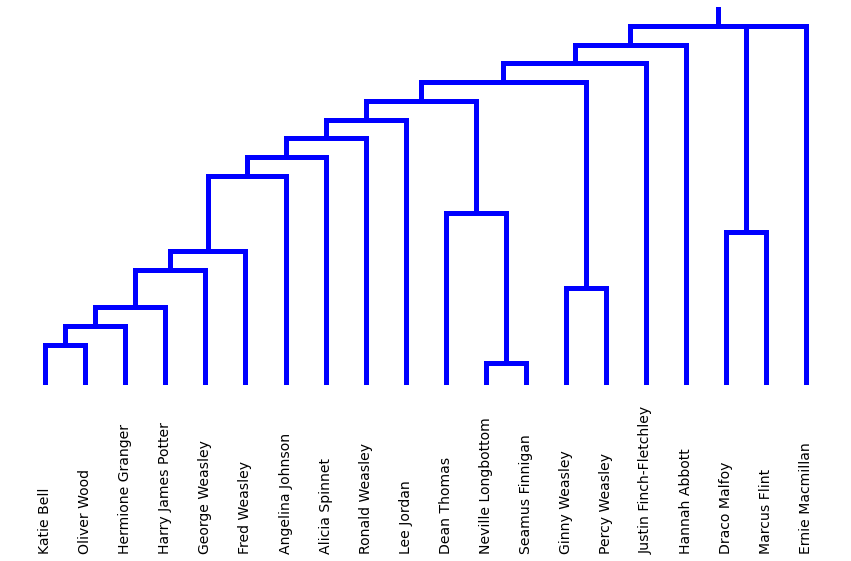

In [275]:
fig, ax = plt.subplots(1,1,figsize=(15,10))

plt.plot([-3.90380859375,-3.90380859375],[0,-20],'b',linewidth=5)
plt.plot([0,-47.8076171875,40,40],[-20,-20,-20,-20],'b', linewidth=5)
plt.plot([40,40],[-20,-400],'b', linewidth=5)
plt.plot([-47.8076171875,-47.8076171875],[-20,-40],'b', linewidth=5)
plt.plot([-75.615234375,-20],[-40,-40],'b', linewidth=5)
plt.plot([-20,-20],[-40,-400],'b', linewidth=5)
plt.plot([-75.615234375,-75.615234375],[-40,-60],'b', linewidth=5)
plt.plot([-111.23046875,-40],[-60,-60],'b', linewidth=5)
plt.plot([-40,-40],[-60,-400],'b', linewidth=5)
plt.plot([-111.23046875,-111.23046875],[-60,-80],'b',linewidth=5)
plt.plot([-152.4609375,-70],[-80,-80],'b', linewidth=5)
# plt.plot([-80,-80],[-80,-100],'b', linewidth=5)
plt.plot([-152.4609375,-152.4609375],[-80,-100],'b', linewidth=5)
plt.plot([-179.921875,-125],[-100,-100],'b', linewidth=5)
# plt.plot([-80,-80],[-80,-100],'b', linewidth=5)
plt.plot([-179.921875,-179.921875],[-100,-120],'b', linewidth=5)
plt.plot([-125,-125],[-100,-220],'b', linewidth=5)
plt.plot([-199.84375,-160],[-120,-120],'b', linewidth=5)
plt.plot([-160,-160],[-120,-400],'b', linewidth=5)
plt.plot([-199.84375,-199.84375],[-120,-140],'b', linewidth=5)
plt.plot([-219.6875,-180],[-140,-140],'b', linewidth=5)
plt.plot([-180,-180],[-140,-400],'b', linewidth=5)
plt.plot([-219.6875,-219.6875],[-140,-160],'b', linewidth=5)
plt.plot([-239.375,-200],[-160,-160],'b', linewidth=5)
plt.plot([-200,-200],[-160,-400],'b', linewidth=5)
plt.plot([-239.375,-239.375],[-160,-180],'b', linewidth=5)
plt.plot([-258.75,-220],[-180,-180],'b', linewidth=5)
plt.plot([-220,-220],[-180,-400],'b', linewidth=5)
# plt.plot([-400,-400],[-180,-200],'b', linewidth=5)
# plt.plot([-120,-120],[-100,-220],'b', linewidth=5)
plt.plot([-140,-120],[-220,-220],'b', linewidth=5)
plt.plot([-140,-140],[-220,-400],'b', linewidth=5)
plt.plot([10,10],[-20,-240],'b', linewidth=5)
plt.plot([00,20],[-240,-240],'b', linewidth=5)
plt.plot([0,0],[-240,-400],'b', linewidth=5)
plt.plot([20,20],[-240,-400],'b', linewidth=5)
plt.plot([-258.75,-258.75],[-180,-260],'b', linewidth=5)
plt.plot([-277.5,-240],[-260,-260],'b', linewidth=5)   
plt.plot([-240,-240],[-260,-400],'b', linewidth=5)

plt.plot([-277.5,-277.5],[-260,-280],'b', linewidth=5)
plt.plot([-295,-260],[-280,-280],'b', linewidth=5)
plt.plot([-260,-260],[-280,-400],'b', linewidth=5)

plt.plot([-70,-70],[-80,-300],'b', linewidth=5)
plt.plot([-80,-60],[-300,-300],'b', linewidth=5)
plt.plot([-80,-80],[-300,-400],'b', linewidth=5)
plt.plot([-60,-60],[-300,-400],'b', linewidth=5)

plt.plot([-295,-295],[-280,-320],'b', linewidth=5)
plt.plot([-315,-280],[-320,-320],'b', linewidth=5)
plt.plot([-280,-280],[-320,-400],'b', linewidth=5)
plt.plot([-315,-315],[-320,-340],'b', linewidth=5)

plt.plot([-340,-320],[-360,-360],'b', linewidth=5)
plt.plot([-340,-340],[-360,-400],'b', linewidth=5)
plt.plot([-320,-320],[-360,-400],'b', linewidth=5)

    
plt.plot([-330,-330],[-340,-360],'b', linewidth=5)
plt.plot([-330,-300],[-340,-340],'b', linewidth=5)
plt.plot([-300,-300],[-340,-400],'b', linewidth=5)


plt.plot([-140,-110],[-220,-220],'b', linewidth=5)
plt.plot([-110,-110],[-220,-380],'b', linewidth=5)
plt.plot([-120,-100],[-380,-380],'b', linewidth=5)
plt.plot([-120,-120],[-380,-400],'b', linewidth=5)
plt.plot([-100,-100],[-380,-400],'b', linewidth=5)

plt.box(False)
plt.xticks([])
plt.yticks([])
plt.ylim(-580,0)
plt.text(-340,-580,gpotter.nodes[28]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)
plt.text(-320,-580,gpotter.nodes[44]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-300,-580,gpotter.nodes[25]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-280,-580,gpotter.nodes[24]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-260,-580,gpotter.nodes[19]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-240,-580,gpotter.nodes[18]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-220,-580,gpotter.nodes[ 2]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-200,-580,gpotter.nodes[ 1]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-180,-580,gpotter.nodes[55]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-160,-580,gpotter.nodes[32]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-140,-580,gpotter.nodes[10]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)
plt.text(-120,-580,gpotter.nodes[43]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)
plt.text(-100,-580,gpotter.nodes[57]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(- 80,-580,gpotter.nodes[20]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)
plt.text(- 60,-580,gpotter.nodes[51]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(- 40,-580,gpotter.nodes[27]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(- 20,-580,gpotter.nodes[23]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(-  0,-580,gpotter.nodes[13]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)
plt.text(+ 20,-580,gpotter.nodes[38]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.text(+ 40,-580,gpotter.nodes[16]['nome'],rotation='vertical',horizontalalignment='center',fontsize=14)

plt.show()

### Agrupamento hierárquico

No agrupamento hierárquicos a ideia é iniciar com os nós isolados, cada um formando uma comunidade unitária, e a cada etapa ir juntando os nós aos grupos de acordo com alguma medida de similaridade de pares de nós.

Algumas medidas podem ser usadas para quantificar a similaridade entre nós. 
No método CONCOR, usamos a correlação de Pearson entre as linhas da matriz de adjacência correspondente a dois nós, como uma medida de similaridade entre eles. 

Outras possibilidades são usar o recíproco da distância Euclideana entre as linhas da matriz, ou o número de nós na rede menos o número de vizinhos que está na vizinhança de apenas um dos nós em cada par.

O **networkx** não tem funções para fazer um agrupamento hierárquico de vértices. 

O pacote **SciPy** tem um sub-pacote, chamado **clustering.hierachical**. 
Entre as funções deste pacote, encontramos **linkage** que constrói agrupamentos hierárquicos usando diversos critérios. 

Alguns desses critérios são:

- **complete linkage**: a similaridade entre dois grupos é medida como a mínima similaridade entre cada par de vértices.

- **single linkage**: a similaridade entre dois grupos é medida como a máxima similaridade entre cada par de vértices.

- **average linkage**: a similaridade entre dois grupos é medida como a média das similaridades entre cada par de vértices.

O algoritmo começa adjuntando os dois vértices que têm a maior similaridade. 
Depois, o algoritmo continua adjuntando dois grupos que têm a maior similaridade, de acordo com o tipo de ligação usada.

In [214]:
import scipy.cluster.hierarchy as hier

In [215]:
# matriz de adjacencia esparsa
A = nx.adjacency_matrix(gpotter)

# matriz de adjacencia densa
A = np.array(A.todense(), dtype = float)

S = np.copy(A.T)

In [216]:
# agrupamento
Z = hier.linkage(S, 'complete', metric='euclidean')

In [217]:
# etiquetas
nomes = [gpotter.nodes[n]['nome'] for n in gpotter.nodes]

**set_link_color_palette()**

Set list of matplotlib color codes for use by dendrogram.

In [218]:
# cores das linhas do grafico
hier.set_link_color_palette(['b'])

**hier.dendrogram()**

Plot the hierarchical clustering as a dendrogram.

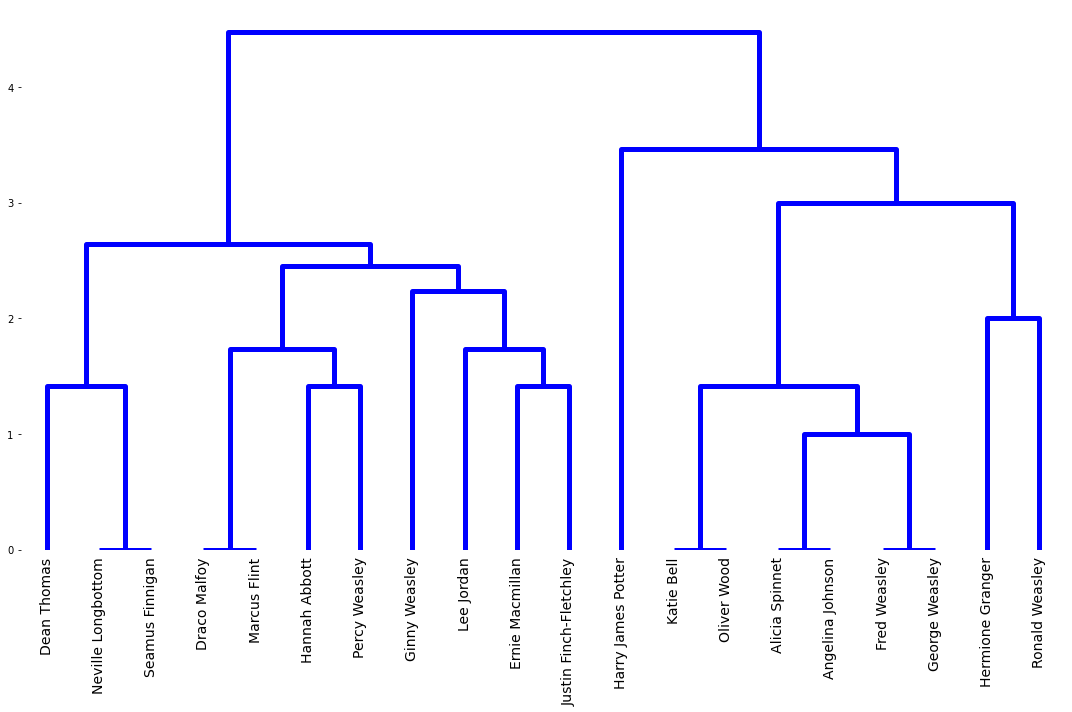

In [219]:
#  Dendrograma de agrupamento hierárquico baseado, aplicado a uma rede de personagens do segundo livro da saga Harry Potter

fig, ax = plt.subplots(1, 1, figsize = (15,10))

with plt.rc_context({'lines.linewidth': 5}):
    dn = hier.dendrogram(Z, 
                         color_threshold = np.inf,
                         leaf_rotation = 'vertical', 
                         leaf_font_size = 14, 
                         labels = nomes )
    
plt.tight_layout()
plt.box(False)
plt.show()